Taken from https://docs.sciml.ai/DiffEqFlux/stable/examples/neural_ode/

In [80]:
using ComponentArrays, Lux, DiffEqFlux, OrdinaryDiffEq, Optimization, OptimizationOptimJL,
      OptimizationOptimisers, Random, Plots

rng = Xoshiro(0)
u0 = Float32[2.0; 0.0]
datasize = 300
tspan = (0.0f0, 5.0f0)
tsteps = range(tspan[1], tspan[2]; length = datasize)

function trueODEfunc(du, u, p, t)
    true_A = [-0.1 2.0; 
              -2.0 -0.1]
    du .= true_A' * (u .^(3))
end

trueODEfunc (generic function with 1 method)

In [81]:
prob_trueode = ODEProblem(trueODEfunc, u0, tspan)
ode_data = Array(solve(prob_trueode, Tsit5(); saveat = tsteps))

2×300 Matrix{Float32}:
 2.0  1.9866    1.97135   1.94917   …  -0.213005  -0.240203  -0.267233
 0.0  0.264883  0.524107  0.775895      0.934483   0.932731   0.930831

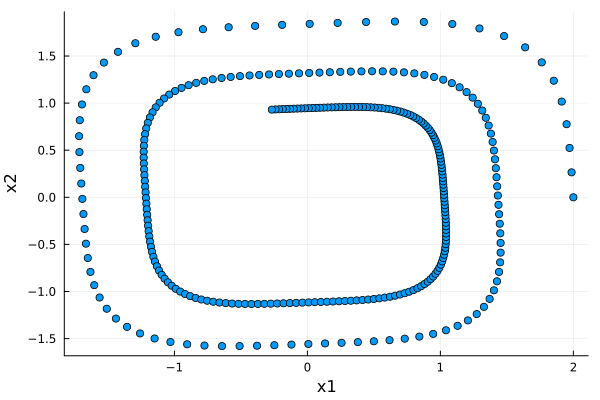

In [82]:
scatter(ode_data[1,:], ode_data[2,:], xlabel = "x1", ylabel = "x2", label = false)

115.86036


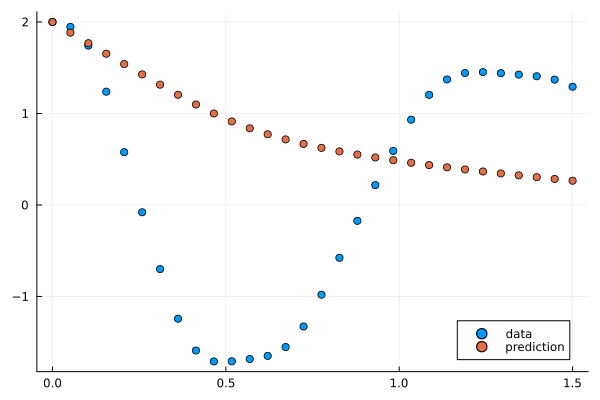

115.86035
134.13521
99.27835
92.63215
89.32282
87.03306
84.99306
82.56468
79.73452
76.60587
72.439514
67.2437
62.427017
56.625782
52.97056
50.6013
48.613667
47.04994
45.784782
44.23216
42.222366
39.13284
37.398243
35.384754
30.670576
27.550142
24.294323
29.025671
26.358442
23.457764
24.131468
20.661516
16.742208
17.598969
13.066257
13.337066
11.669731
8.986569
11.092119
7.16056
8.233813
7.068477
5.321755
7.8614006
5.32603
6.8701253
5.819733
4.710464
6.6139174
4.452785
5.2234097
5.5284367
4.440001
4.690931
4.8952837
4.0291924
4.385229
4.300064
3.7461116
3.7757173
3.8968499
3.3595407
3.3351824
3.4359248
3.0390363
3.0290227
3.1024332
2.7266703
2.7935076
2.7009206
2.5055683
2.5156038
2.4469745
2.2857983
2.2793186
2.2102566
2.0812492
2.1117465
1.9680967
1.929555
1.9035933
1.8060459
1.8355683
1.7543063
1.7098585
1.6637012
1.604763
1.6580862
1.5274881
1.5467103
1.4636921
1.4488618
1.3996984
1.3836035
1.3427114
1.3164498
1.2921938
1.264904
1.251873
1.2196596
1.1935962
1.1721035
1.1550037
1.133

LoadError: Output should be scalar; gradients are not defined for output (0.07898955f0, Float32[2.0 1.9173198 1.7586272 1.2724204 0.61099166 -0.054105222 -0.7139517 -1.2975123 -1.6015415 -1.7032709 -1.6907225 -1.6600136 -1.6230832 -1.5369897 -1.3393103 -1.0005062 -0.60644984 -0.20112507 0.19404745 0.5808209 0.94965607 1.2039341 1.3428893 1.4248134 1.4486006 1.4396262 1.4237881 1.4035648 1.3509085 1.185733; 0.0 0.7170975 1.3822383 1.7448591 1.8289328 1.8259835 1.8100533 1.6782818 1.3311245 0.88023406 0.35767627 -0.1576285 -0.66059345 -1.1278589 -1.469219 -1.6182269 -1.6248097 -1.5829924 -1.5445111 -1.509264 -1.4425323 -1.2864754 -1.069278 -0.81263435 -0.50689554 -0.17923605 0.14344199 0.4573334 0.7697725 1.0745152])

In [ ]:
dudt2 = Chain(x -> x .^ 3, Dense(2, 50, tanh), Dense(50, 2))
p, st = Lux.setup(rng, dudt2)
prob_neuralode = NeuralODE(dudt2, tspan, Tsit5(); saveat = tsteps)

function predict_neuralode(p)
    Array(prob_neuralode(u0, p, st)[1])
end

function loss_neuralode(p)
    pred = predict_neuralode(p)
    loss = sum(abs2, ode_data .- pred)
    return loss, pred
end

# Do not plot by default for the documentation
# Users should change doplot=true to see the plots callbacks
callback = function (p, l, pred; doplot = false)
    println(l)
    # plot current prediction against data
    if doplot
        plt = scatter(tsteps, ode_data[1, :]; label = "data")
        scatter!(plt, tsteps, pred[1, :]; label = "prediction")
        display(plot(plt))
    end
    return false
end

pinit = ComponentArray(p)
callback(pinit, loss_neuralode(pinit)...; doplot = true)

# use Optimization.jl to solve the problem
adtype = Optimization.AutoZygote()

optf = Optimization.OptimizationFunction((x, p) -> loss_neuralode(x), adtype)
optprob = Optimization.OptimizationProblem(optf, pinit)

result_neuralode = Optimization.solve(
    optprob, OptimizationOptimisers.Adam(0.05); callback = callback, maxiters = 300)

optprob2 = remake(optprob; u0 = result_neuralode.u)

result_neuralode2 = Optimization.solve(
    optprob2, Optim.BFGS(; initial_stepnorm = 0.01); callback, allow_f_increases = false)

callback(result_neuralode2.u, loss_neuralode(result_neuralode2.u)...; doplot = true)

In [5]:
using ComponentArrays, Lux, DiffEqFlux, OrdinaryDiffEq, Optimization, OptimizationOptimJL,
      OptimizationOptimisers, Random, Plots

rng = Xoshiro(0)
u0 = Float32[2.0; 0.0]
datasize = 30
tspan = (0.0f0, 1.5f0)
tsteps = range(tspan[1], tspan[2]; length = datasize)

function trueODEfunc(du, u, p, t)
    true_A = [-0.1 2.0; -2.0 -0.1]
    du .= ((u .^ 3)'true_A)'
end

prob_trueode = ODEProblem(trueODEfunc, u0, tspan)
ode_data = Array(solve(prob_trueode, Tsit5(); saveat = tsteps))

2×30 Matrix{Float32}:
 2.0  1.9465    1.74178  1.23837  0.577127  …  1.40688   1.37023   1.29214
 0.0  0.798832  1.46473  1.80877  1.86465      0.451377  0.728699  0.972102

In [6]:
dudt2 = Chain(x -> x .^ 3, Dense(2, 50, tanh), Dense(50, 2))
p, st = Lux.setup(rng, dudt2)
prob_neuralode = NeuralODE(dudt2, tspan, Tsit5(); saveat = tsteps)

NeuralODE(
    model = Chain(
        layer_1 = WrappedFunction(#22),
        layer_2 = Dense(2 => 50, tanh),  # 150 parameters
        layer_3 = Dense(50 => 2),       # 102 parameters
    ),
)         # Total: 252 parameters,
          #        plus 0 states.

In [7]:
dudt2 = Chain(x -> x .^ 3, Dense(2, 50, tanh), Dense(50, 2))

Chain(
    layer_1 = WrappedFunction(#24),
    layer_2 = Dense(2 => 50, tanh),     # 150 parameters
    layer_3 = Dense(50 => 2),           # 102 parameters
)         # Total: 252 parameters,
          #        plus 0 states.

In [8]:
function predict_neuralode(p)
    Array(prob_neuralode(u0, p, st)[1])
end

function loss_neuralode(p)
    pred = predict_neuralode(p)
    loss = sum(abs2, ode_data .- pred)
    return loss, pred
end

loss_neuralode (generic function with 1 method)

In [9]:
# Callback function to observe training
callback = function (p, l, pred; doplot = false)
    println(l)
    # plot current prediction against data
    if doplot
        plt = scatter(tsteps, ode_data[1, :]; label = "data")
        scatter!(plt, tsteps, pred[1, :]; label = "prediction")
        display(plot(plt))
    end
    return false
end

pinit = ComponentArray(p)
callback(pinit, loss_neuralode(pinit)...)

115.86036


false

In [14]:
# Train using the Adam optimizer
adtype = Optimization.AutoZygote()

optf = Optimization.OptimizationFunction((x, p) -> loss_neuralode(x), adtype)
optprob = Optimization.OptimizationProblem(optf, pinit)

result_neuralode = Optimization.solve(
    optprob, OptimizationOptimisers.Adam(0.05); callback = callback, maxiters = 300)

115.86035
134.13521
99.27835
92.63215
89.32282
87.03306
84.99306
82.56468
79.73452
76.60587
72.439514
67.2437
62.427017
56.625782
52.97056
50.6013
48.613667
47.04994
45.784782
44.23216
42.222366
39.13284
37.398243
35.384754
30.670576
27.550142
24.294323
29.025671
26.358442
23.457764
24.131468
20.661516
16.742208
17.598969
13.066257
13.337066
11.669731
8.986569
11.092119
7.16056
8.233813
7.068477
5.321755
7.8614006
5.32603
6.8701253
5.819733
4.710464
6.6139174
4.452785
5.2234097
5.5284367
4.440001
4.690931
4.8952837
4.0291924
4.385229
4.300064
3.7461116
3.7757173
3.8968499
3.3595407
3.3351824
3.4359248
3.0390363
3.0290227
3.1024332
2.7266703
2.7935076
2.7009206
2.5055683
2.5156038
2.4469745
2.2857983
2.2793186
2.2102566
2.0812492
2.1117465
1.9680967
1.929555
1.9035933
1.8060459
1.8355683
1.7543063
1.7098585
1.6637012
1.604763
1.6580862
1.5274881
1.5467103
1.4636921
1.4488618
1.3996984
1.3836035
1.3427114
1.3164498
1.2921938
1.264904
1.251873
1.2196596
1.1935962
1.1721035
1.1550037
1.133

LoadError: Output should be scalar; gradients are not defined for output (0.07898955f0, Float32[2.0 1.9173198 1.7586272 1.2724204 0.61099166 -0.054105222 -0.7139517 -1.2975123 -1.6015415 -1.7032709 -1.6907225 -1.6600136 -1.6230832 -1.5369897 -1.3393103 -1.0005062 -0.60644984 -0.20112507 0.19404745 0.5808209 0.94965607 1.2039341 1.3428893 1.4248134 1.4486006 1.4396262 1.4237881 1.4035648 1.3509085 1.185733; 0.0 0.7170975 1.3822383 1.7448591 1.8289328 1.8259835 1.8100533 1.6782818 1.3311245 0.88023406 0.35767627 -0.1576285 -0.66059345 -1.1278589 -1.469219 -1.6182269 -1.6248097 -1.5829924 -1.5445111 -1.509264 -1.4425323 -1.2864754 -1.069278 -0.81263435 -0.50689554 -0.17923605 0.14344199 0.4573334 0.7697725 1.0745152])

In [15]:
# Retrain using the LBFGS optimizer
optprob2 = remake(optprob; u0 = result_neuralode.u)

result_neuralode2 = Optimization.solve(optprob2, Optim.BFGS(; initial_stepnorm = 0.01);
    callback = callback, allow_f_increases = false)

LoadError: UndefVarError: `result_neuralode` not defined

In [13]:
callback(result_neuralode2.u, loss_neuralode(result_neuralode2.u)...; doplot = true)
scatter!(plt, tsteps, loss_neuralode(result_neuralode2.u)[2][1, :]; label = "prediction") # hide

LoadError: UndefVarError: `result_neuralode2` not defined